In [ ]:
# point_e -> A system for generating 3D Point Clouds from complex prompts
# Image to Point Cloud - Here

In [ ]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 1.56 MiB | 10.47 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
%cd point-e
!pip install -e .

/content/point-e
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-1_oxkahg/clip_a40bcd9545654fb188e95dedb9f18a06
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-1_oxkahg/clip_a40bcd9545654fb188e95dedb9f18a06
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=6143a92b749637629dc415e3414c80231cdcbc85f464c81546176479f2917c5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-b38mqrlp/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filen

In [ ]:
from PIL import Image  # Python Image Library - get images to condition on
import torch  # ML Library - load the point_e model and generate images
from tqdm.auto import tqdm  # show the progress bar

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base300M' # use base300M or base1B for better results - more parameters means better accuracy
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))


creating base model...
creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [26]:
# Load an image to condition on.

# img = Image.open('/content/point-e/point-e/point_e/examples/example_data/corgi.jpg')  -> working with images provided with point_e
img = Image.open('/content/car.jpg')  # working with your local images

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x


0it [00:00, ?it/s]

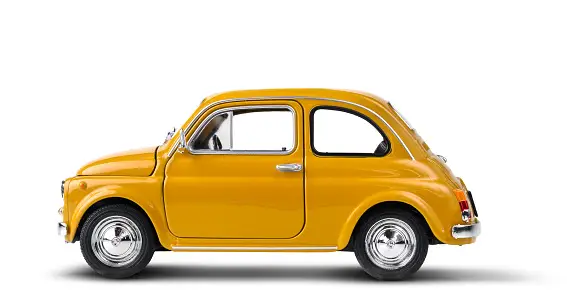

In [27]:
# View Base Image

img

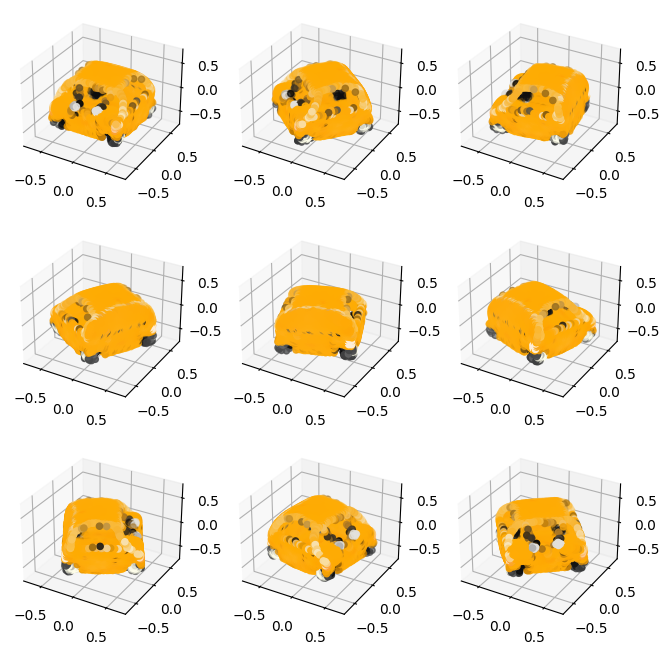

In [28]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))